In [1]:
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# fix random seeds
rng_seed = 0
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)

from xopt import Xopt
from xopt.evaluator import Evaluator
from xopt.generators import ExpectedImprovementGenerator
from xopt.generators.bayesian.options import ModelOptions, OptimOptions
from xopt.generators.bayesian.expected_improvement import BayesianOptions
from lume_model.torch import LUMEModule

from utils import NegativeTransverseBeamSize, LinearMismatch
from utils import load_surrogate, running_max, create_vocs, print_runtime
from custom_mean import LinearCalibration

In [2]:
# load surrogate model and define objective
surrogate = load_surrogate("configs/lcls_variables.yml", "configs/normalization.json", "torch_model.pt")
objective_name = "negative_sigma_xy"
vocs = create_vocs(surrogate, objective_name)
surrogate_module = LUMEModule(surrogate, vocs.variable_names, ["sigma_x", "sigma_y"])
Objective = NegativeTransverseBeamSize
ground_truth = Objective(surrogate_module)

# Xopt evaluator function
def evaluate(input_dict):
    model_result = surrogate.evaluate(input_dict)
    obj_kwargs = {key:model_result[key] for key in surrogate_module.output_order}
    obj_value = Objective.function(**obj_kwargs).detach().item()
    return {objective_name: obj_value}

In [3]:
# define custom mean
x_dim = len(surrogate_module.feature_order)
y_dim = len(vocs.objective_names)

mismatch_scale = 0.3
x_shift = mismatch_scale * torch.rand(x_dim)
x_scale = torch.ones(x_dim) + mismatch_scale * torch.rand(x_dim)
y_shift = mismatch_scale * torch.rand(1)
y_scale = torch.ones(1) + mismatch_scale * torch.rand(1)

mismatched_gt = LinearMismatch(
    function=ground_truth,
    x_dim=x_dim,
    x_shift=x_shift,
    x_scale=x_scale,
    y_shift=y_shift,
    y_scale=y_scale,
)

custom_mean = LinearCalibration(
    mismatched_gt,
    x_dim=x_dim,
    y_dim=y_dim,
)

In [4]:
n_init = 3
inputs_init = pd.DataFrame(vocs.random_inputs(n=n_init, seed=rng_seed))
outputs = [evaluate(inputs_init.to_dict(orient="index")[i])[objective_name] for i in range(len(inputs_init))]
outputs_init = pd.DataFrame({objective_name: outputs})
data_init = pd.concat([inputs_init, outputs_init], axis=1)
data_init

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,negative_sigma_xy
0,0.315416,11.849845,0.218563,-0.008702,-0.007148,3.845480,-0.490601,3.625577,-2.844318,1.115676,-4.508010,-4.770960,4.084017,250.0,58000000.0,70000000.0,-2.673201
1,0.421819,4.680301,0.210919,-0.006318,0.009328,-20.211281,-4.794569,1.987560,-2.153845,2.887162,-2.112335,-3.202335,1.662885,250.0,58000000.0,70000000.0,-1.464008
2,0.488126,3.785076,0.222483,0.009938,-0.004593,-8.954229,9.007755,2.057821,-3.982130,3.097626,-0.082182,-1.481926,1.395637,250.0,58000000.0,70000000.0,-2.367977


In [5]:
n_step = 50
model_options = ModelOptions(
    name="trainable_mean_standard",
    mean_modules={objective_name: custom_mean}
)
optim_options = OptimOptions(num_restarts=5, raw_samples=20)
generator_options = BayesianOptions(model=model_options, optim=optim_options)
generator = ExpectedImprovementGenerator(vocs, options=generator_options)
evaluator = Evaluator(function=evaluate)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs, data=data_init)

t0 = time.time()
for i in range(n_step):
    X.step()

# print runtime
print_runtime(t0, time.time())

Runtime: 10.15 min


In [6]:
# print data set
X.data

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,negative_sigma_xy,xopt_runtime,xopt_error
1,0.315416,11.849845,0.218563,-0.008702,-0.007148,3.845480,-0.490601,3.625577,-2.844318,1.115676,-4.508010,-4.770960,4.084017,250.0,58000000.0,70000000.0,-2.673201,NaN,NaN
2,0.421819,4.680301,0.210919,-0.006318,0.009328,-20.211281,-4.794569,1.987560,-2.153845,2.887162,-2.112335,-3.202335,1.662885,250.0,58000000.0,70000000.0,-1.464008,NaN,NaN
3,0.488126,3.785076,0.222483,0.009938,-0.004593,-8.954229,9.007755,2.057821,-3.982130,3.097626,-0.082182,-1.481926,1.395637,250.0,58000000.0,70000000.0,-2.367977,NaN,NaN
4,0.467048,7.614967,0.223556,0.009993,0.005970,-14.804133,-2.504420,2.008634,-1.789697,6.800421,-5.695631,-2.699895,6.314750,250.0,58000000.0,70000000.0,-0.528114,0.000638,False
5,0.471621,7.834928,0.194091,0.007449,0.009999,-20.252777,-24.999726,1.114070,-2.357505,6.076606,-1.668696,0.999301,2.806118,250.0,58000000.0,70000000.0,-4.501000,0.000707,False
6,0.290273,11.998570,0.242225,0.009993,0.009999,-11.752574,4.221312,2.237658,-1.010512,1.009736,-3.256618,0.915773,1.029746,250.0,58000000.0,70000000.0,-1.457596,0.000732,False
7,0.500000,8.828527,0.256303,0.009993,0.009999,-6.186815,-19.579847,3.878507,-3.904910,5.472712,0.998352,-5.347996,6.993748,250.0,58000000.0,70000000.0,-2.350769,0.000614,False
8,0.372311,4.484023,0.247369,0.009993,0.009999,-21.623588,-24.999726,1.000040,-2.769744,6.999777,-2.951525,-3.528675,6.998086,250.0,58000000.0,70000000.0,-2.544431,0.000714,False
9,0.211190,11.998570,0.246255,0.009993,0.009999,6.394305,-18.877951,1.000040,-1.559307,5.728462,-3.492396,-5.089259,6.997930,250.0,58000000.0,70000000.0,-0.518336,0.000751,False
10,0.500000,11.998570,0.195846,0.009993,0.009999,-23.019997,-7.922925,1.000040,-1.010512,4.820136,0.998352,-5.918632,6.998086,250.0,58000000.0,70000000.0,-0.414298,0.000702,False


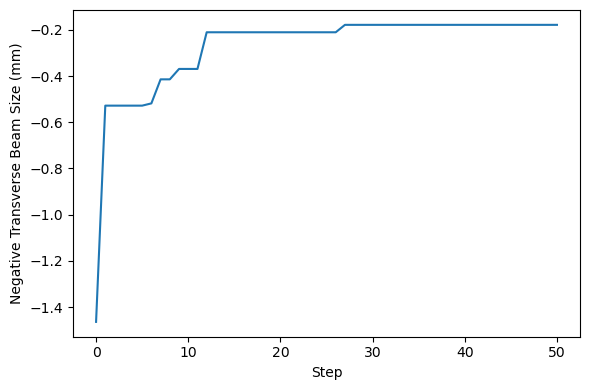

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x = torch.arange(n_step + 1)
y = torch.from_numpy(X.data[objective_name].values)
ax.plot(x, running_max(y.squeeze())[n_init - 1:], "C0-")
ax.set_xlabel("Step")
ax.set_ylabel("{} ({})".format(ground_truth.name, ground_truth.unit))
fig.tight_layout()

In [8]:
# evaluate input calibration
custom_mean = X.generator.model.models[0].mean_module._model
if hasattr(custom_mean, "x_shift") and hasattr(custom_mean, "x_scale"):
    print("{:<5s} {:>10s} {:>10s} {:>10s} {:>10s}".format("x_dim", "x_shift", "learned", "x_scale", "learned"))
    for i in range(x_dim):
        x_shifts = (mismatched_gt.x_shift.detach()[i], -custom_mean.x_shift.detach()[i])
        x_scales = (mismatched_gt.x_scale.detach()[i], 1 / custom_mean.x_scale.detach()[i])
        print("{:<5d} {:10.2f} {:10.2f} {:10.2f} {:10.2f}".format(i, *x_shifts, *x_scales))
        if i == x_dim - 1: print()

# evaluate output calibration
if hasattr(custom_mean, "y_shift") and hasattr(custom_mean, "y_scale"):
    print("{:<5s} {:>10s} {:>10s} {:>10s} {:>10s}".format("y_dim", "y_shift", "learned", "y_scale", "learned"))
    for i in range(y_dim):
        y_shifts = (mismatched_gt.y_shift.detach()[i], -custom_mean.y_shift.detach()[i])
        y_scales = (mismatched_gt.y_scale.detach()[i], 1 / custom_mean.y_scale.detach()[i])
        print("{:<5d} {:10.2f} {:10.2f} {:10.2f} {:10.2f}".format(i, *y_shifts, *y_scales))

x_dim    x_shift    learned    x_scale    learned
0           0.15       0.12       1.05       1.00
1           0.23       0.00       1.09       1.00
2           0.03       0.00       1.16       1.00
3           0.04       0.00       1.21       1.00
4           0.09       0.00       1.24       1.00
5           0.19       0.00       1.05       1.00
6           0.15       0.00       1.08       1.00
7           0.27       0.00       1.20       1.00
8           0.14       0.00       1.27       1.00
9           0.19       0.21       1.12       1.02
10          0.10       0.16       1.26       1.01
11          0.12      -0.00       1.13       1.00
12          0.01       0.00       1.17       1.00

y_dim    y_shift    learned    y_scale    learned
0           0.29      -0.00       1.01       1.04
